Author: Khai Nguyen

Project:
In this project, I will use the PyTorch library to create and train a Generative Adversarial Network (GAN). I'll implement the model from scratch, following these steps; create a dataset, define the generator and discriminator neural networks, define their update rules, and finally implement the training function.



Introduction

Project Description
Generative Adversarial Networks (GANs) are deep neural networks trained to generate data distributions that are not identifiable as being synthetic. Two neural networks are trained in parallel to accomplish this–the generator and the discriminator. The discriminator's job is to identify a sample as either real or synthetic. The generator's job is to generate samples that fool the discriminator into classifying them as real.

Let's say we wanted to create a classification model on a dataset with a high class imbalance. When we trained the model, we got an excellent accuracy score, but when we made a confusion matrix, we saw that the model only predicted one class. Oversampling and undersampling are two solutions to the class imbalance problem. The former includes the minority class samples multiple times, which gives duplicate samples in the dataset. The latter drops a chunk of the majority class samples, which results in the loss of valuable data samples. To resolve these problems, we can use GANs to generate synthetic data for the minority class. This will ensure that there are no duplicate samples and that the classes are equally represented in the dataset. Any model trained on this data will, therefore, learn to predict both classes.

We'll create a GAN from scratch for dataset augmentation in this project. We'll use PyTorch for machine learning and Matplotlib for visualizations. Automatic differentiation will be used to train the deep learning models. The generator will be trained so that its generated distribution closely matches the actual distribution of the data.

# Importing the library

In [1]:
import time
import torch
from torch import nn # create discriminator and generartor with nn
import matplotlib.pyplot as plt
from matplotlib import rcParams # set the size of the visualization
from IPython import display

%matplotlib inline

Create the dataset, visualize it, and define a dataset iterator that will be used to generate sample batches for model training.

Generate a dataset that approximates a linear relationship between the two variables. Use matrix multiplications to create the dataset using the following formula:

Y = XA + b




In [2]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

In [3]:
print(len(data))

1000




1.   [What is torch normal](https://pytorch.org/docs/stable/generated/torch.normal.html)
2.   [How detach() work in pytorch](https://www.geeksforgeeks.org/tensor-detach-method-in-python-pytorch/)



# Explore Data

Create a scatterplot data



1.   List item
2.   List item



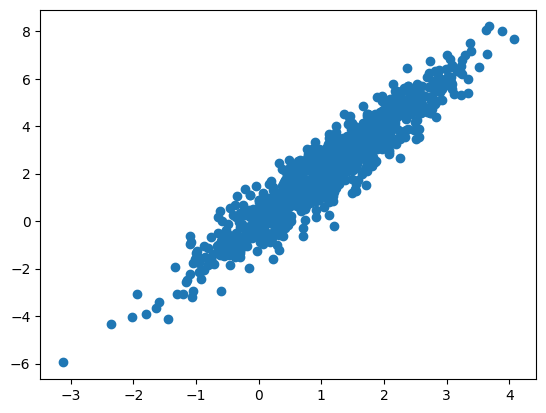

In [4]:
plt.scatter(data[:,0], data[:, 1])

### Generate dataset iterator

In [5]:
batch_size = 8
dataset = torch.utils.data.TensorDataset(data)
data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

# Build Model

## Define Generators and Discriminators

Define the generator using the sequential() method from the torch.nn module. The model requires the following input:

Module: The Linear() module requires as input the following parameters:

in_features: The number of input features.

out_features: The number of output features.


In [6]:
nnet_Gen = nn.Sequential(nn.Linear(2, 2))

Define the discriminator using the sequential() method from the torch.nn module. The model requires the following input:

Module:

The Linear() module requires as input the following parameters:

in_features: The number of input features.

out_features: The number of output features.

The tanh() module applies the element-wise hyperbolic tangent function on the outputs of the previous layer.

In [7]:
nnet_Disc = nn.Sequential(
  nn.Linear(2, 5), nn.Tanh(),
  nn.Linear(5, 3), nn.Tanh(),
  nn.Linear(3, 1))

## Define the function for discriminator updates



1.   [Why we should do the detach](https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor)
2.   List item



Define the function for discriminator updates. The function takes the input:

- x: This is the training batch
- Z: These are the seed values for generating the fake batch
- nnet_D: this is the discriminator nn
- nnet_G: this is the generator nn
- loss: This is the loss function
- trainer_D: This is the optim


Use the real and synthetic data to compute the loss. Compute the loss on the discriminator outputs for the real batch with a tensor of ones and zero for synthetic batch. Ones mean real, zeros mean fakes. The final loss is an average of the two. This is becuase the discriminator's job is to correctly classify the two distributions as seperate.

In [8]:
def update_D(X, Z, nnet_D, nnet_G, loss, trainer_D):
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = nnet_D(X)
    synth_X = nnet_G(Z)
    synth_Y = nnet_D(synth_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(synth_Y, zeros.reshape(synth_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D



## Perform Generator Updates

Define the function for performing updates on the generator. Use the noise  given as input  to generate a synthetic batch and make predictions using the discriminator. Then comput the loss on these prediction with ones, computer the gradient and update.

In [9]:
def update_G(Z, nnet_D, nnet_G, loss, trainer_G):
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    synth_X = nnet_G(Z)
    synth_Y = nnet_D(synth_X)
    loss_G = loss(synth_Y, ones.reshape(synth_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G


# Initialize the parameters

Define the method for initializing parameters for training. The function takes as input the following parameters:

**Discriminator:** This is the discriminator neural network.

**Generator:** This is the generator neural network.

**lr_D**: This is the learning rate of the discriminator.

**lr_G:** This is the learning rate of the generator.
The function will make the following returns:

**loss:** This is an instance of the loss function that we have chosen.

**trainer_D:** This is the optimizer of the discriminator.

**trainer_G:** This is the optimizer of the generator.

**fig:** This is the figure for visualizations.

**axes:** This is an array of axes on which we will plot the visualizations.

**loss_D:** This array will save the loss generated in the discriminator over the current batch.

**loss_G:** This array will save the loss generated in the generator over the current batch.







The function will perform the following:

Initialize loss as an instance of the BCEWithLogitsLoss() class. This loss applies a sigmoid layer to the outputs before applying the BCELoss() (Binary Cross Entropy Loss) and is numerically more stable than using the sigmoid and the BCELoss() separately.

Use normal_() from torch.nn.init to initialize the parameters of the generator and the discriminator neural networks.

Use model.parameters() to access the parameters of the respective model. The init() function requires as parameters the following:

tensor: This is a tensor of the parameters you want to initialize.

mean: This is the mean of the normal distribution you need to sample these parameters from.

std: This is the standard deviation of the normal distribution you need to sample these parameters from.

Initialize the optimizers/trainers of the two neural networks as objects of the Adam() class from torch.optim. Adam is an extended version of the stochastic gradient descent optimizer. This method accepts as input the following parameters:

params: These are the model parameters that will be trained.

lr: This is the learning rate of the optimizer.
Configure matplotlib to show multiple plots in the figure using plt.subplots(). This function will take the following inputs:

nrows: This is the number of rows in the figure.
ncols: This is the number of columns in the figure.

figsize: This is a tuple of the plot dimensions.
Create two empty lists named loss_D and loss_G. These will store the losses of the two neural networks.


( [How to use Pytorch loss function](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-pytorch-loss-functions.md))

In [10]:


def init_params(Discriminator, Generator, lr_D, lr_G):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in Discriminator.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in Generator.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(Discriminator.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(Generator.parameters(), lr=lr_G)
    fig, axes = plt.subplots(2, 1, figsize=(5, 9))
    loss_D = []
    loss_G = []

    return loss, trainer_D, trainer_G, fig, axes, loss_D, loss_G

# Compute the loss

This function will initialize a noise array, compute the loss, and aggregate them into an array

The function require these parameters:

- X: input batch
- net_D, net_G, loss:
- Trainer_D
- Trainer_G
- batch_size
- latent_dim: the number of input features of the generator
- data_iter: this is the dataset iterator I have created before

The function will return the following:

metrics: This array will save the loss generated in the discriminator and the generator along with the number of samples processed in the epoch.

In [11]:
def compute_losses(X, net_D, net_G, loss, trainer_D, trainer_G, batch_size, latent_dim, data_iter):
    metrics = [0.0]*3
    for (X,) in data_iter:
        batch_size = X.shape[0]
        Z = torch.normal(0, 1, size=(batch_size, latent_dim))
        metric = [update_D(X, Z, net_D, net_G, loss, trainer_D),
                    update_G(Z, net_D, net_G, loss, trainer_G),
                    batch_size]
        metrics = [sum(i) for i in zip(metric, metrics)]

    return metrics

### Display the data distribution generated by the generator at each epoch and losses


In [12]:
def display_gen_dist(net_G, axes, latent_dim, data):
    Z = torch.normal(0, 1, size=(100, latent_dim))
    synth_X = net_G(Z).detach().numpy()
    axes[1].cla()
    axes[1].scatter(data[:, 0], data[:, 1])
    axes[1].scatter(synth_X[:, 0], synth_X[:, 1])
    axes[1].legend(['real', 'generated'])

In [13]:
def display_losses(metrics, loss_D, loss_G, axes, fig, epoch):
    D = metrics[0]/metrics[2]
    loss_D.append(D.detach())
    G = metrics[1]/metrics[2]
    loss_G.append(G.detach())
    axes[0].plot(range(epoch+1), loss_D, c="blue")
    axes[0].plot(range(epoch+1), loss_G, c="green")
    axes[0].legend(['Discriminator loss', 'Generator loss'])
    display.display(fig)
    display.clear_output(wait=True)

    return loss_D, loss_G

### Training the model

In [14]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    # Start timer
    tik = time.perf_counter()
    # Init variables
    loss, trainer_D, trainer_G, fig, axes, loss_D, loss_G = init_params(net_D, net_G, lr_D, lr_G)
    for epoch in range(num_epochs):
        # Train one epoch
        metrics = compute_losses(X, net_D, net_G, loss, trainer_D, trainer_G, batch_size, latent_dim, data_iter)
        # Visualize generated examples
        display_gen_dist(net_G, axes, latent_dim, data)
        # Show the losses
        loss_D, loss_G = display_losses(metrics, loss_D, loss_G, axes, fig, epoch)
    # End timer
    tok = time.perf_counter()
    # Display stats
    print(f'loss_D {loss_D[-1]}, loss_G {loss_G[-1]}, {(metrics[2]*num_epochs) / (tok-tik):.1f} examples/sec')

loss_D 0.693101704120636, loss_G 0.6932659149169922, 909.8 examples/sec


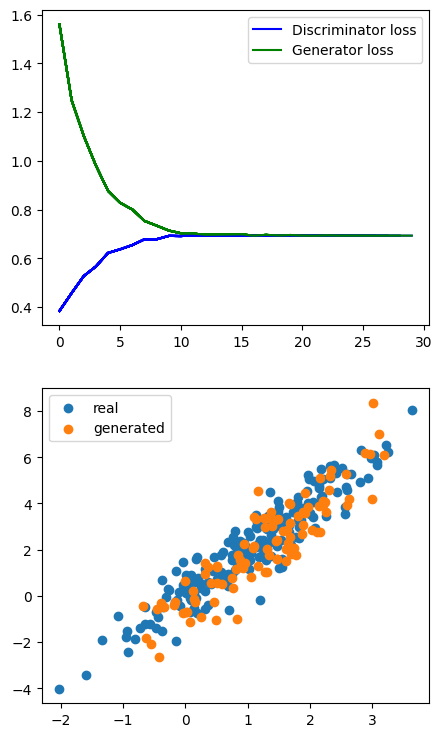

In [15]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 30
train(nnet_Disc, nnet_Gen, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:200].detach().numpy())

Conclustion:

Developed a GAN from scratch using PyTorch and Matplotlib for dataset augmentation, optimizing generator's output distribution with automatic differentiation to enhance AI model performance through data enrichment.